## SGD Classifier: Logistic Regression & Support Vector Machine

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from monai.data import Dataset
from monai.transforms import Compose, LoadImage, ScaleIntensity, EnsureType
import pydicom
import pickle
import h5py
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.patients = [f for f in sorted(os.listdir(image_dir)) if "PANCREAS" in f]
        self.max_depth = self.calculate_max_depth()

    def calculate_max_depth(self):
        max_depth = 0
        for patient_folder in self.patients:
            patient_image_dir = os.path.join(self.image_dir, patient_folder)
            volume = self.load_dicom_volume(patient_image_dir)
            if volume.shape[0] > max_depth:
                max_depth = volume.shape[0]
        return max_depth

    def load_dicom_volume(self, patient_image_dir):
        subfolder = next(os.walk(patient_image_dir))[1][0]
        deepest_folder = next(os.walk(os.path.join(patient_image_dir, subfolder)))[1][0]
        final_path = os.path.join(patient_image_dir, subfolder, deepest_folder)
        files = sorted(os.listdir(final_path), key=lambda x: pydicom.dcmread(os.path.join(final_path, x)).InstanceNumber)
        volume = np.stack([pydicom.dcmread(os.path.join(final_path, f)).pixel_array for f in files])
        return torch.from_numpy(volume).float()

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_folder = self.patients[idx]
        patient_image_dir = os.path.join(self.image_dir, patient_folder)
        patient_label_path = os.path.join(self.label_dir, f"label{patient_folder.split('_')[-1]}.nii.gz")
        volume = self.load_dicom_volume(patient_image_dir)
        label = LoadImage(image_only=True)(patient_label_path)
        label = np.transpose(label, (2, 0, 1))
        label = torch.from_numpy(label).float()
        pad_size = self.max_depth - volume.shape[0]
        volume = torch.nn.functional.pad(volume, (0, 0, 0, 0, 0, pad_size))
        label = torch.nn.functional.pad(label, (0, 0, 0, 0, 0, pad_size))
        volume = volume.permute(2, 1, 0).unsqueeze(-1)
        label = label.permute(2, 1, 0).unsqueeze(-1)
        if self.transforms:
            volume = self.transforms(volume)
            label = self.transforms(label)
        return volume.squeeze(0), label.squeeze(0)

# Transforms and DataLoader
transforms = Compose([
    ScaleIntensity(),
    EnsureType(dtype=torch.float32)
])

# Paths
image_root_dir = "/Users/lukeyun/SDS323/manifest-1599750808610/Pancreas-CT"
label_root_dir = "/Users/lukeyun/SDS323/TCIA_pancreas_labels-02-05-2017"

dataset = MedicalImageDataset(image_root_dir, label_root_dir, transforms=transforms)

def create_data_loaders(dataset, batch_size=1):
    total_size = len(dataset)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(832)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_data_loaders(dataset, batch_size=1)


In [3]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Determine empirical class proportions
empirical_class_props = np.array([0., 0.], dtype=np.float64)
for batch in train_loader:
    _, counts = np.unique(batch[1].numpy(), return_counts=True)
    empirical_class_props += counts / counts.sum()

empirical_class_props /= len(train_loader)

# Normalize the proportions so they sum to 1
# NOTE: This should just be happening with the previous line
# but it seems like there is some sort of roundoff error leading the sum to be 0.999...
# This seems like it is more stable
empirical_class_props /= empirical_class_props.sum()

# Calculate weights inversely proportional to class proportions
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes,
                                     y=np.array([0]*int(empirical_class_props[0]*10000) + [1]*int(empirical_class_props[1]*10000)))

# Convert class weights to dict for rf
class_weights_dict = dict(zip(classes, class_weights))

### Logistic Regression

##### Training

In [ ]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import pickle

def batch_train_log(train_loader, clf):
    first_batch = True
    for features, labels in train_loader:
        # Squeeze the singleton channel dimension and flatten the spatial dimensions
        # features shape: [batch, height, width, depth, 1] -> [batch, height * width * depth]
        flat_features = features.view(features.size(0), -1).numpy()  # Ensure 2D array
        # Flatten labels to 1D
        flat_labels = labels.view(labels.size(0), -1).numpy()

        for i in range(features.size(0)):
            feature_batch = flat_features[i].reshape(-1, 1)
            label_batch = flat_labels[i]
            print("Feature batch shape:", feature_batch.shape)
            print("Label batch shape:", label_batch.shape)
            print("Unique labels in batch:", np.unique(label_batch))

            if first_batch:
                clf.fit(feature_batch, label_batch)
                first_batch = False
            else:
                clf.partial_fit(feature_batch, label_batch, classes=np.array([0, 1]))

    return clf

# Initialize the classifier with the logistic regression loss
clf = SGDClassifier(loss='log_loss', class_weight=class_weights_dict, random_state=832, warm_start=True)

# Train the model
clf = batch_train_log(train_loader, clf)

# Save model
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(clf, file)

##### Validation

In [ ]:
import pickle

# Load model
lr_filename = "./logistic_regression_model.pkl"
clf = pickle.load(open(lr_filename, 'rb'))

In [ ]:
import numpy as np
from joblib import Parallel, delayed

def prep_data_lr(data_loader):
    all_features = []
    all_labels = []

    for features, labels in data_loader:
        # Reshape features to [batch_size * (height * width * depth), 1] and flatten labels
        flat_features = features.view(-1, 1).numpy()  # Features are 2D array with a single feature per row
        flat_labels = labels.view(-1).numpy()  # Flatten labels to a 1D array

        all_features.append(flat_features)
        all_labels.append(flat_labels)

    # Concatenate everything
    all_features = np.vstack(all_features)
    all_labels = np.concatenate(all_labels)

    return all_features, all_labels

def predict_batch(clf, features):
    return clf.predict(features)

def incremental_val(clf, features, batch_size=10000, n_jobs=-1):
    num_samples = features.shape[0]
    pred = np.empty(num_samples, dtype=np.float32)
    
    # Generate ranges for each batch
    ranges = [(start, min(start + batch_size, num_samples)) for start in range(0, num_samples, batch_size)]
    
    # Parallel prediction
    results = Parallel(n_jobs=n_jobs)(delayed(predict_batch)(clf, features[start:end].reshape(-1, 1)) for start, end in ranges)
    
    # Concatinate
    count = 1
    for i, (start, end) in enumerate(ranges):
        pred[start:end] = results[i]
        if i % 20000 == 0:
            print(f"{count * 10}% of pixels processed")
            count += 1
    
    return pred

In [ ]:
val_features, val_labels = prep_data_lr(val_loader)
lr_pred = incremental_val(clf, val_features)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

lr_pred = lr_pred.astype(np.float32)
# Flatten if not already
# lr_pred = lr_pred.flatten()
# print(f"Flattened array shape: {lr_pred.shape}")#


# Calculate overall metrics
avg_acc = accuracy_score(val_labels, lr_pred)
avg_prec = precision_score(val_labels, lr_pred)
avg_rec = recall_score(val_labels, lr_pred)
avg_f1 = f1_score(val_labels, lr_pred)


print(f"Average Validation Accuracy: {avg_acc}")
print(f"Average Validation Precision: {avg_prec}")
print(f"Average Validation Recall: {avg_rec}")
print(f"Average Validation F1 Score: {avg_f1}")

In [ ]:
num_volumes = 16
height = 512
width = 512
depth = 466

# Reshape predictions into 2D array where each index is predictions
# for corresponding validation volume
lr_pred = lr_pred.reshape(num_volumes, height, width, depth)

# Reshape features and labels back to normal
features = val_features.squeeze(1).reshape(num_volumes, height, width, depth)
labels = val_labels.reshape(num_volumes, height, width, depth)

print(f"Reshaped features are back to shape {features.shape}")
print(f"Reshaped labels are back to shape {labels.shape}")
print(f"Reshaped predictions are of shape {lr_pred.shape}")

In [ ]:
import h5py

with h5py.File('logistic_regression_predictions.hdf5', 'w') as f:
    for i, pred in enumerate(lr_pred):
        f.create_dataset(f'lr_predictions_batch_{i}', data=pred)
        print(f"Finished saving predictions for validation batch {i+1}")

In [ ]:
import h5py
import numpy as np

# Open the HDF5 file in read mode
with h5py.File('logistic_regression_predictions.hdf5', 'r') as file:
    # Initialize a list to hold data from each batch
    all_batches = []
    
    # Sorted to ensure that batches are added in the correct order
    for name in sorted(file.keys()):
        # Load each dataset into memory and append to the list
        data = file[name][()]
        all_batches.append(data)
        print(f"Loaded data for {name}, shape: {data.shape}")
    
    # Stack all batches along a new axis to create a single array
    lr_pred = np.stack(all_batches, axis=0)
    print(f"Combined array shape: {lr_pred.shape}")

In [ ]:
plot_2d_volume_label_prediction_triples(val_loader, lr_pred, num_pairs=2)

### Support Vector Machine

##### Training

In [3]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import pickle

def batch_train_log(train_loader, clf):
    first_batch = True
    for features, labels in train_loader:
        # Squeeze the singleton channel dimension and flatten the spatial dimensions
        # features shape: [batch, height, width, depth, 1] -> [batch, height * width * depth]
        flat_features = features.view(features.size(0), -1).numpy()  # Ensure 2D array
        # Flatten labels to 1D
        flat_labels = labels.view(labels.size(0), -1).numpy()

        for i in range(features.size(0)):
            feature_batch = flat_features[i].reshape(-1, 1)
            label_batch = flat_labels[i]
            print("Feature batch shape:", feature_batch.shape)
            print("Label batch shape:", label_batch.shape)
            print("Unique labels in batch:", np.unique(label_batch))

            if first_batch:
                clf.fit(feature_batch, label_batch)
                first_batch = False
            else:
                clf.partial_fit(feature_batch, label_batch, classes=np.array([0, 1]))

    return clf

# Initialize the classifier with the logistic regression loss
clf = SGDClassifier(loss='hinge', class_weight=class_weights_dict, random_state=832, warm_start=True)

# Train the model
clf = batch_train_log(train_loader, clf)

# Save model
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(clf, file)

Feature batch shape: (122159104, 1)
Label batch shape: (122159104,)
Unique labels in batch: [0. 1.]
Feature batch shape: (122159104, 1)
Label batch shape: (122159104,)
Unique labels in batch: [0. 1.]
Feature batch shape: (122159104, 1)
Label batch shape: (122159104,)
Unique labels in batch: [0. 1.]
Feature batch shape: (122159104, 1)
Label batch shape: (122159104,)
Unique labels in batch: [0. 1.]
Feature batch shape: (122159104, 1)
Label batch shape: (122159104,)
Unique labels in batch: [0. 1.]
Feature batch shape: (122159104, 1)
Label batch shape: (122159104,)
Unique labels in batch: [0. 1.]
Feature batch shape: (122159104, 1)
Label batch shape: (122159104,)
Unique labels in batch: [0. 1.]
Feature batch shape: (122159104, 1)
Label batch shape: (122159104,)
Unique labels in batch: [0. 1.]
Feature batch shape: (122159104, 1)
Label batch shape: (122159104,)
Unique labels in batch: [0. 1.]
Feature batch shape: (122159104, 1)
Label batch shape: (122159104,)
Unique labels in batch: [0. 1.]


##### Validation Dataset and Testing

In [4]:
svm_filename = "./svm_model.pkl"
clf = pickle.load(open(svm_filename, 'rb'))

In [11]:
import numpy as np
from joblib import Parallel, delayed

def prep_data_svm(data_loader):
    all_features = []
    all_labels = []

    for features, labels in data_loader:
        # Reshape features to [batch_size * (height * width * depth), 1] and flatten labels
        flat_features = features.view(-1, 1).numpy()  # Features are 2D array with a single feature per row
        flat_labels = labels.view(-1).numpy()  # Flatten labels to a 1D array

        all_features.append(flat_features)
        all_labels.append(flat_labels)

    # Concatenate everything
    all_features = np.vstack(all_features)
    all_labels = np.concatenate(all_labels)

    return all_features, all_labels

def predict_batch(clf, features):
    return clf.predict(features)

def incremental_val(clf, features, batch_size=10000, n_jobs=-1):
    num_samples = features.shape[0]
    pred = np.empty(num_samples, dtype=np.float32)
    
    # Generate ranges for each batch
    ranges = [(start, min(start + batch_size, num_samples)) for start in range(0, num_samples, batch_size)]
    
    # Parallel prediction
    results = Parallel(n_jobs=n_jobs)(delayed(predict_batch)(clf, features[start:end].reshape(-1, 1)) for start, end in ranges)
    
    # Concatinate
    count = 1
    for i, (start, end) in enumerate(ranges):
        pred[start:end] = results[i]
        if i % 20000 == 0:
            print(f"{count * 10}% of pixels processed")
            count += 1
    
    return pred

In [12]:
val_features, val_labels = prep_data_svm(val_loader)
svm_pred = incremental_val(clf, val_features)

10% of pixels processed
20% of pixels processed
30% of pixels processed
40% of pixels processed
50% of pixels processed
60% of pixels processed
70% of pixels processed
80% of pixels processed
90% of pixels processed
100% of pixels processed


In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

svm_pred = svm_pred.astype(np.float32)
# Flatten if not already
# lr_pred = lr_pred.flatten()
# print(f"Flattened array shape: {lr_pred.shape}")#


# Calculate overall metrics
avg_acc = accuracy_score(val_labels, svm_pred)
avg_prec = precision_score(val_labels, svm_pred)
avg_rec = recall_score(val_labels, svm_pred)
avg_f1 = f1_score(val_labels, svm_pred)


print(f"Average Validation Accuracy: {avg_acc}")
print(f"Average Validation Precision: {avg_prec}")
print(f"Average Validation Recall: {avg_rec}")
print(f"Average Validation F1 Score: {avg_f1}")

Average Validation Accuracy: 0.5624827525134762
Average Validation Precision: 0.001627781012125936
Average Validation Recall: 0.741192327597808
Average Validation F1 Score: 0.0032484279389121623


In [14]:
num_volumes = 16
height = 512
width = 512
depth = 466

# Reshape predictions into 2D array where each index is predictions
# for corresponding validation volume
svm_pred = svm_pred.reshape(num_volumes, height, width, depth)

# Reshape features and labels back to normal
features = val_features.squeeze(1).reshape(num_volumes, height, width, depth)
labels = val_labels.reshape(num_volumes, height, width, depth)

print(f"Reshaped features are back to shape {features.shape}")
print(f"Reshaped labels are back to shape {labels.shape}")
print(f"Reshaped predictions are of shape {svm_pred.shape}")

Reshaped features are back to shape (16, 512, 512, 466)
Reshaped labels are back to shape (16, 512, 512, 466)
Reshaped predictions are of shape (16, 512, 512, 466)


In [15]:
import h5py

with h5py.File('svm_predictions.hdf5', 'w') as f:
    for i, pred in enumerate(svm_pred):
        f.create_dataset(f'svm_predictions_batch_{i}', data=pred)
        print(f"Finished saving predictions for validation batch {i+1}")

Finished saving predictions for validation batch 1
Finished saving predictions for validation batch 2
Finished saving predictions for validation batch 3
Finished saving predictions for validation batch 4
Finished saving predictions for validation batch 5
Finished saving predictions for validation batch 6
Finished saving predictions for validation batch 7
Finished saving predictions for validation batch 8
Finished saving predictions for validation batch 9
Finished saving predictions for validation batch 10
Finished saving predictions for validation batch 11
Finished saving predictions for validation batch 12
Finished saving predictions for validation batch 13
Finished saving predictions for validation batch 14
Finished saving predictions for validation batch 15
Finished saving predictions for validation batch 16


In [16]:
import h5py
import numpy as np

# Open the HDF5 file in read mode
with h5py.File('svm_predictions.hdf5', 'r') as file:
    # Initialize a list to hold data from each batch
    all_batches = []
    
    # Sorted to ensure that batches are added in the correct order
    for name in sorted(file.keys()):
        # Load each dataset into memory and append to the list
        data = file[name][()]
        all_batches.append(data)
        print(f"Loaded data for {name}, shape: {data.shape}")
    
    # Stack all batches along a new axis to create a single array
    svm_pred = np.stack(all_batches, axis=0)
    print(f"Combined array shape: {svm_pred.shape}")

Loaded data for svm_predictions_batch_0, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_1, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_10, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_11, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_12, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_13, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_14, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_15, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_2, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_3, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_4, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_5, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_6, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_7, shape: (512, 512, 466)
Loaded data for svm_predictions_batch_8, shape: (512, 512, 466)
Loaded data for svm_predictions_ba

In [17]:
import matplotlib.pyplot as plt

def plot_2d_volume_label_prediction_triples(dataloader, predictions, num_pairs=5):
    fig, axes = plt.subplots(num_pairs, 3, figsize=(15, num_pairs * 5))
    
    # Corner case
    if num_pairs == 1:
        axes = [axes]
    
    for i, (volume, label) in enumerate(dataloader):
        if i >= num_pairs:
            break
        
        # Handle batches
        volume = volume.squeeze(0)
        label = label.squeeze(0)
        prediction = predictions[i]
        
        ax1, ax2, ax3 = axes[i]
        
        # Taking the middle depth slice
        mid_slice_index = volume.shape[2] // 2
        volume_slice = volume[:, :, mid_slice_index].numpy()
        label_slice = label[:, :, mid_slice_index].numpy()
        prediction_slice = prediction[:, :, mid_slice_index]
        
        ax1.imshow(volume_slice, cmap='gray')
        ax1.set_title(f'Patient {i+1} - Image')
        ax1.axis('off') 
        
        ax2.imshow(label_slice, cmap='gray')
        ax2.set_title(f'Patient {i+1} - Label')
        ax2.axis('off')
        
        ax3.imshow(prediction_slice, cmap='gray')
        ax3.set_title(f'Patient {i+1} - Prediction')
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

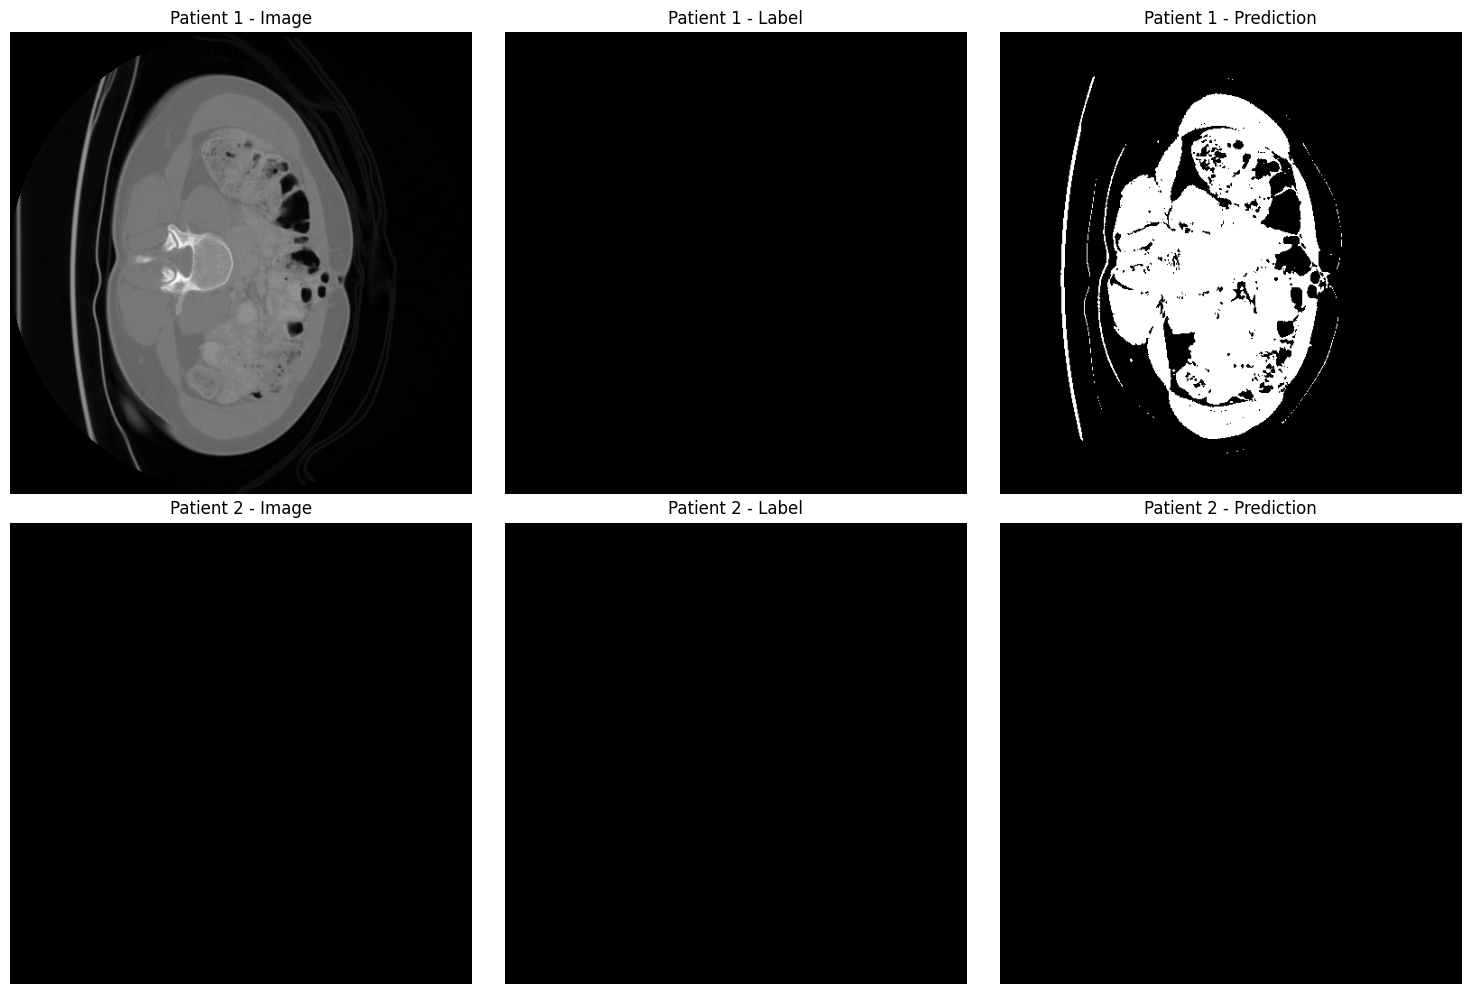

In [18]:
plot_2d_volume_label_prediction_triples(val_loader, svm_pred, num_pairs=2)

In [21]:
# Freeing up memory
del svm_pred